In [ ]:
from google.colab import drive
import sys
import os
import random
import numpy as np
import cv2

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
tf.executing_eagerly()

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/ADNI'
batch = 12
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

In [ ]:
import os
import cv2
#DataFolders
data_folder = "/content/drive/My Drive/Colab Notebooks/ADNI/Processed/train"

data_AD = data_folder + "/AD/"
data_CN = data_folder + "/CN/"
data_MCI = data_folder + "/MCI/"


In [ ]:
RESIZE_TO = 224

x, y = [], []
for path in [f for f in os.listdir(data_AD) if f[-4:] == ".png"]:
    x.append(cv2.resize(cv2.imread(data_AD + path), (RESIZE_TO, RESIZE_TO)))
    y.append("AD")
for path in [f for f in os.listdir(data_CN) if f[-4:] == ".png"]:
    x.append(cv2.resize(cv2.imread(data_CN + path), (RESIZE_TO, RESIZE_TO)))
    y.append("CN")
for path in [f for f in os.listdir(data_MCI) if f[-4:] == ".png"]:
    x.append(cv2.resize(cv2.imread(data_MCI + path), (RESIZE_TO, RESIZE_TO)))
    y.append("MCI")


In [ ]:
print(' Number of AD:', len(os.listdir(data_AD)))
print(' Number of CN:', len(os.listdir(data_CN)))
print(' Number of MCI:', len(os.listdir(data_MCI)))

 Number of AD: 4977
 Number of CN: 6804
 Number of MCI: 7434


In [ ]:
#Resnet
x_res = np.array(x)
x_res = tf.keras.applications.resnet.preprocess_input(x_res, data_format = None)

In [ ]:
RESIZE_TO = 299

x_299 = []

for path in [f for f in os.listdir(data_AD) if f[-4:] == ".png"]:
    x_299.append(cv2.resize(cv2.imread(data_AD + path), (RESIZE_TO, RESIZE_TO)))
for path in [f for f in os.listdir(data_CN) if f[-4:] == ".png"]:
    x_299.append(cv2.resize(cv2.imread(data_CN + path), (RESIZE_TO, RESIZE_TO)))
for path in [f for f in os.listdir(data_MCI) if f[-4:] == ".png"]:
    x_299.append(cv2.resize(cv2.imread(data_MCI + path), (RESIZE_TO, RESIZE_TO)))


In [ ]:
#Xception
x_cept = np.array(x)
x_cept = tf.keras.applications.xception.preprocess_input(x_cept, data_format = None)

In [ ]:
#y_test
from sklearn.preprocessing import LabelEncoder
y = np.array(y)
le = LabelEncoder()
le.fit(["AD", "CN", "MCI"])
y = le.transform(y)

In [ ]:
#Loading Resnet Model

# Add the pretrained layers
pretrained_model = keras.applications.ResNet50(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout 
drop = keras.layers.Dropout(0.3)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(3, activation='softmax')(dropout)

# Get the model
model_1 = keras.Model(inputs=pretrained_model.input, outputs=output)

#model_1.summary()

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#Load the saved model
model_1.load_weights(filepath=abspath_curr + '/result/Batch32_Epoch20_Dropout3/ResNet50_model.h5')

# Compile the model
model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',    
              metrics=['accuracy'])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["AD", "CN", "MCI"]

y_pred_res = model_1.predict(x_res)
pred_res = np.argmax(y_pred_res, axis=1)

print(classification_report(y, pred_res, target_names=class_names_tr))
print("Accuracy : ", accuracy_score(y, pred_res) * 100)
#print("\n")

              precision    recall  f1-score   support

          AD       0.00      0.00      0.00      1260
          CN       0.00      0.00      0.00      1638
         MCI       0.39      1.00      0.56      1827

    accuracy                           0.39      4725
   macro avg       0.13      0.33      0.19      4725
weighted avg       0.15      0.39      0.22      4725

Accuracy :  38.666666666666664


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Loading Xception Model

# Add the pretrained layers
pretrained_model = keras.applications.Xception(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout 20%
drop = keras.layers.Dropout(0.3)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(3, activation='softmax')(dropout)

# Get the model
model_2 = keras.Model(inputs=pretrained_model.input, outputs=output)

#model_2.summary()

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Load the saved model
model_2.load_weights(filepath=abspath_curr + '/result/Batch32_Epoch20_Dropout3/Xception_model.h5')

# Compile the model
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["AD", "CN", "MCI"]

y_pred_xcept = model_2.predict(x_cept)
pred_xcept = np.argmax(y_pred_xcept, axis=1)
print(classification_report(y, pred_xcept, target_names=class_names_tr))
print("Accuracy : ", accuracy_score(y, pred_xcept) * 100)
print("\n")

              precision    recall  f1-score   support

          AD       0.00      0.00      0.00      1260
          CN       0.35      1.00      0.51      1638
         MCI       0.00      0.00      0.00      1827

    accuracy                           0.35      4725
   macro avg       0.12      0.33      0.17      4725
weighted avg       0.12      0.35      0.18      4725

Accuracy :  34.66666666666667




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Loading VGG16 Model

# Add the pretrained layers
pretrained_model = keras.applications.VGG16(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout
drop = keras.layers.Dropout(0.3)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(3, activation='softmax')(dropout)
model_3 = keras.Model(inputs=pretrained_model.input, outputs=output)

# Load the saved model
model_3.load_weights(filepath=abspath_curr + '/result/Batch32_Epoch20_Dropout3/VGG16_model.h5')

# Compile the model
model_3.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["AD", "CN", "MCI"]

#Classification report - VGG16
y_pred_VGG16 = model_3.predict(x_res)
pred_VGG16 = np.argmax(y_pred_VGG16, axis=1)
print(classification_report(y, pred_VGG16, target_names=class_names_tr))
print('VGG16 Results')
print("Accuracy : ", accuracy_score(y, pred_VGG16) * 100)
print("\n")

              precision    recall  f1-score   support

          AD       0.34      0.21      0.26      1260
          CN       0.43      0.19      0.26      1638
         MCI       0.40      0.71      0.52      1827

    accuracy                           0.40      4725
   macro avg       0.39      0.37      0.35      4725
weighted avg       0.40      0.40      0.36      4725

VGG16 Results
Accuracy :  39.74603174603175




In [ ]:
print(pred_VGG16)

[0 0 0 ... 2 2 2]


In [ ]:
import pandas as pd
#Combining the models
#df1 = pd.DataFrame(y_pred_res, columns = ["AD1", "MCI1", "CN1"])
#df2 = pd.DataFrame(y_pred_xcept, columns = ["AD2", "MCI2", "CN2"])
df3 = pd.DataFrame(y_pred_VGG16, columns = ["AD", "CN", "MCI"])
df_target = pd.DataFrame(y, columns = ['target'])
df_prediction = pd.DataFrame(pred_VGG16, columns = ['Prediction'])

#df1['AD2'] = df2['AD2']
#df1['MCI2'] = df2['MCI2']
#df1['CN2'] = df2['CN2']

#df1['AD3'] = df3['AD3']
#df1['MCI3'] = df3['MCI3']
#df1['CN3'] = df3['CN3']

df3['Prediction'] = df_prediction["Prediction"]
df3['target'] = df_target['target']


In [ ]:
df3

,AD,CN,MCI,Prediction,target
0,0.847497,0.011103,0.141400,0,0
1,0.603664,0.028212,0.368124,0,0
2,0.725854,0.020129,0.254017,0,0
3,0.755491,0.015272,0.229237,0,0
4,0.373517,0.036698,0.589785,2,0
...,...,...,...,...,...
4720,0.000001,0.139585,0.860414,2,2
4721,0.000002,0.237171,0.762828,2,2
4722,0.000002,0.305360,0.694638,2,2
4723,0.000087,0.117170,0.882744,2,2


In [ ]:


df3.to_csv('/content/drive/My Drive/Colab Notebooks/ADNI/vgg16_model.csv')

In [ ]:
#df1
#df1.to_csv('/content/drive/My Drive/Colab Notebooks/ADNI/two_models.csv')
df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ADNI/two_models.csv')
df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ADNI/xcept_model.csv')

df1['AD2'] = df2['AD2']
df1['MCI2'] = df2['MCI2']
df1['CN2'] = df2['CN2']

df1 = df1.drop(columns = 'Unnamed: 0')
df1["target2"] = df1['target']
df1 = df1.drop(columns = 'target')
df1

,AD1,MCI1,CN1,AD3,MCI3,CN3,AD2,MCI2,CN2,target2
0,9.214346e-20,6.742872e-14,1.0,0.847497,0.011103,0.141400,0.046516,0.720030,0.233454,0
1,3.946282e-19,3.843768e-14,1.0,0.603664,0.028212,0.368124,0.045042,0.729867,0.225091,0
2,1.933365e-18,3.992186e-14,1.0,0.725854,0.020129,0.254017,0.053342,0.695042,0.251616,0
3,4.832964e-20,1.091512e-13,1.0,0.755491,0.015272,0.229237,0.049365,0.697357,0.253278,0
4,3.879945e-20,5.343521e-14,1.0,0.373517,0.036698,0.589785,0.046366,0.710148,0.243486,0
...,...,...,...,...,...,...,...,...,...,...
4720,1.004243e-16,3.933217e-14,1.0,0.000001,0.139585,0.860414,0.054238,0.688985,0.256777,2
4721,3.265491e-16,5.044110e-15,1.0,0.000002,0.237171,0.762828,0.055761,0.684246,0.259992,2
4722,6.673517e-16,3.962764e-15,1.0,0.000002,0.305360,0.694638,0.056479,0.674723,0.268797,2
4723,3.544116e-16,2.448784e-15,1.0,0.000087,0.117170,0.882744,0.056122,0.679722,0.264156,2


In [ ]:
df1['AD_Average'] = (df1['AD2'] + df1['AD3'])/2
df1['CN_Average'] = (df1['CN2'] + df1['CN3'])/2
df1['MCI_Average'] = (df1['MCI2'] + df1['MCI3'])/2

In [ ]:
df1

,AD1,MCI1,CN1,AD3,MCI3,CN3,AD2,MCI2,CN2,target2,AD_Average,CN_Average,MCI_Average
0,9.214346e-20,6.742872e-14,1.0,0.847497,0.011103,0.141400,0.046516,0.720030,0.233454,0,0.447007,0.187427,0.365567
1,3.946282e-19,3.843768e-14,1.0,0.603664,0.028212,0.368124,0.045042,0.729867,0.225091,0,0.324353,0.296608,0.379039
2,1.933365e-18,3.992186e-14,1.0,0.725854,0.020129,0.254017,0.053342,0.695042,0.251616,0,0.389598,0.252817,0.357586
3,4.832964e-20,1.091512e-13,1.0,0.755491,0.015272,0.229237,0.049365,0.697357,0.253278,0,0.402428,0.241258,0.356314
4,3.879945e-20,5.343521e-14,1.0,0.373517,0.036698,0.589785,0.046366,0.710148,0.243486,0,0.209941,0.416636,0.373423
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4720,1.004243e-16,3.933217e-14,1.0,0.000001,0.139585,0.860414,0.054238,0.688985,0.256777,2,0.027119,0.558596,0.414285
4721,3.265491e-16,5.044110e-15,1.0,0.000002,0.237171,0.762828,0.055761,0.684246,0.259992,2,0.027882,0.511410,0.460708
4722,6.673517e-16,3.962764e-15,1.0,0.000002,0.305360,0.694638,0.056479,0.674723,0.268797,2,0.028241,0.481718,0.490042
4723,3.544116e-16,2.448784e-15,1.0,0.000087,0.117170,0.882744,0.056122,0.679722,0.264156,2,0.028104,0.573450,0.398446


In [ ]:
one = df1.iloc[0:63]
print(sum(one['AD_Average'])/63)
print(sum(one['CN_Average'])/63)
print(sum(one['MCI_Average'])/63)

0.09082497785022486
0.49048953618253954
0.4186854832746032


In [ ]:
#https://github.com/amir-jafari/Data-Mining/blob/master/9-Random%20Forest/1-Example_Exercise/RF_1.py
# %%%%%%%%%%%%% Random Forest  %%%%%%%%%%%%%%%%%%%%%%%%%%
#%%-----------------------------------------------------------------------
# Importing the required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [ ]:
# import Dataset
# read data as panda dataframe
data = df1

# printing the dataswet rows and columns
print("Dataset No. of Rows: ", data.shape[0])
print("Dataset No. of Columns: ", data.shape[1])

# printing the dataset obseravtions
print("Dataset first few rows:\n ")
print(data.head(2))

Dataset No. of Rows:  4725
Dataset No. of Columns:  10
Dataset first few rows:
 
            AD1          MCI1  CN1       AD3      MCI3       CN3       AD2  \
0  9.214346e-20  6.742872e-14  1.0  0.847497  0.011103  0.141400  0.046516   
1  3.946282e-19  3.843768e-14  1.0  0.603664  0.028212  0.368124  0.045042   

       MCI2       CN2  target2  
0  0.720030  0.233454        0  
1  0.729867  0.225091        0  


In [ ]:
#clean the dataset
print("Sum of NULL values in each column. ")
print(data.isnull().sum())

Sum of NULL values in each column. 
AD1        0
MCI1       0
CN1        0
AD3        0
MCI3       0
CN3        0
AD2        0
MCI2       0
CN2        0
target2    0
dtype: int64


In [ ]:
#split the dataset
# separate the predictor and target variable
X = data.values[:, 0:9]
Y = data.values[:, 9]

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [ ]:
#perform training with random forest with all columns
# specify random forest classifier
clf = RandomForestClassifier(n_estimators=100)

# perform training
clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# predicton on test using all features
y_pred = clf.predict(X_test)
y_pred_score = clf.predict_proba(X_test)

In [ ]:
# calculate metrics gini model

print("\n")
print("Results Using All Features: \n")

print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("\n")

print("Accuracy : ", accuracy_score(y_test, y_pred) * 100)
print("\n")

#print("ROC_AUC : ", roc_auc_score(y_test,y_pred_score[:,1]) * 100)



Results Using All Features: 

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.49      0.41      0.44       392
         1.0       0.52      0.52      0.52       492
         2.0       0.51      0.57      0.54       534

    accuracy                           0.51      1418
   macro avg       0.51      0.50      0.50      1418
weighted avg       0.51      0.51      0.50      1418



Accuracy :  50.70521861777151




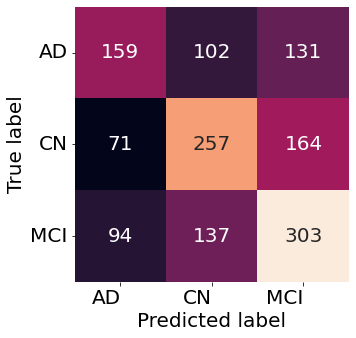

In [ ]:
# confusion matrix for gini model
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ["AD", "CN", "MCI"]


df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names )

plt.figure(figsize=(5,5))

hm = sns.heatmap(df_cm, cbar=False, annot=True, square=True, fmt='d', annot_kws={'size': 20}, yticklabels=df_cm.columns, xticklabels=df_cm.columns)

hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
# Show heat map
plt.tight_layout()

In [ ]:
#Make df of results

df_test = pd.DataFrame(y_pred_score, columns = ["AD", "CN", "MCI"])
df_target = pd.DataFrame(y, columns = ['Actual'])
df_target2 = pd.DataFrame(y_pred, columns = ['Predicted'])
df_test['Predicted'] = df_target2['Predicted']
df_test['Actual'] = df_target['Actual']
df_test['Predicted'].replace({0: "AD", 1: "CN", 2: "MCI"}, inplace=True)
df_test["Actual"].replace({0: "AD", 1: "CN", 2: "MCI"}, inplace=True)
print(df_test)

            AD        CN       MCI Predicted Actual
0     0.500000  0.150000  0.350000        AD     AD
1     0.424095  0.312952  0.262952        AD     AD
2     0.240000  0.340000  0.420000       MCI     AD
3     0.370000  0.470000  0.160000        CN     AD
4     0.226542  0.189865  0.583593       MCI     AD
...        ...       ...       ...       ...    ...
1413  0.163978  0.443426  0.392595        CN     CN
1414  0.140769  0.433333  0.425897        CN     CN
1415  0.560000  0.290000  0.150000        AD     CN
1416  0.180000  0.730000  0.090000        CN     CN
1417  0.080000  0.740000  0.180000        CN     CN

[1418 rows x 5 columns]


In [ ]:
#Create Table from Dataframe

df = df_test
df1 = df.iloc[1354:1417]
final_prediction1 = df1['Predicted'].value_counts()
print(final_prediction1)
df2 = df.iloc[63:126]
final_prediction2 = df2['Predicted'].value_counts()
#print(final_prediction2)
df3 = df.iloc[126:189]
final_prediction3 = df3['Predicted'].value_counts()
#print(final_prediction3)

df4 = df.iloc[189:252]

MCI    27
CN     21
AD     15
Name: Predicted, dtype: int64


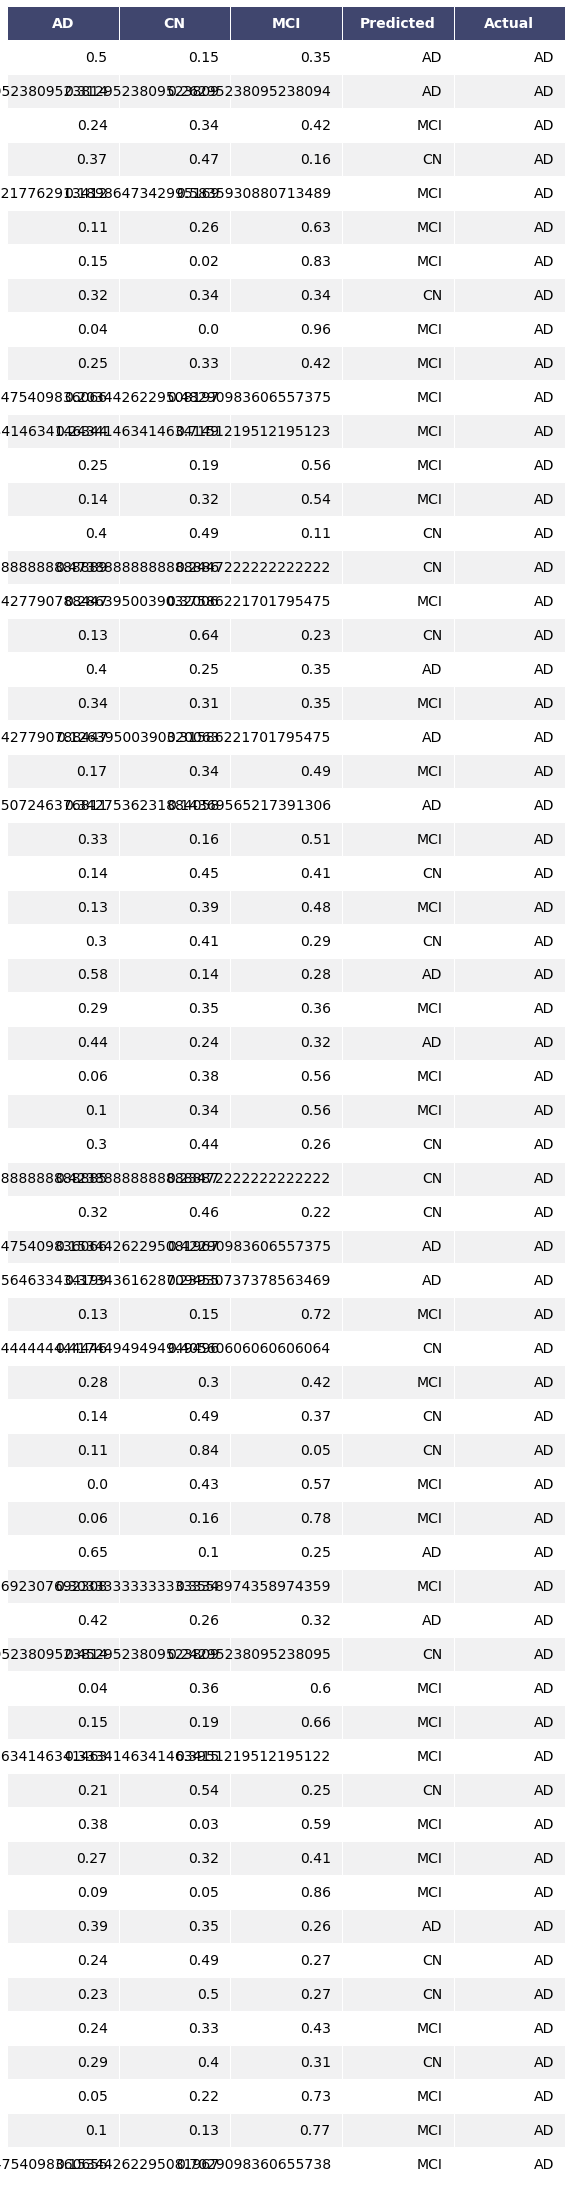

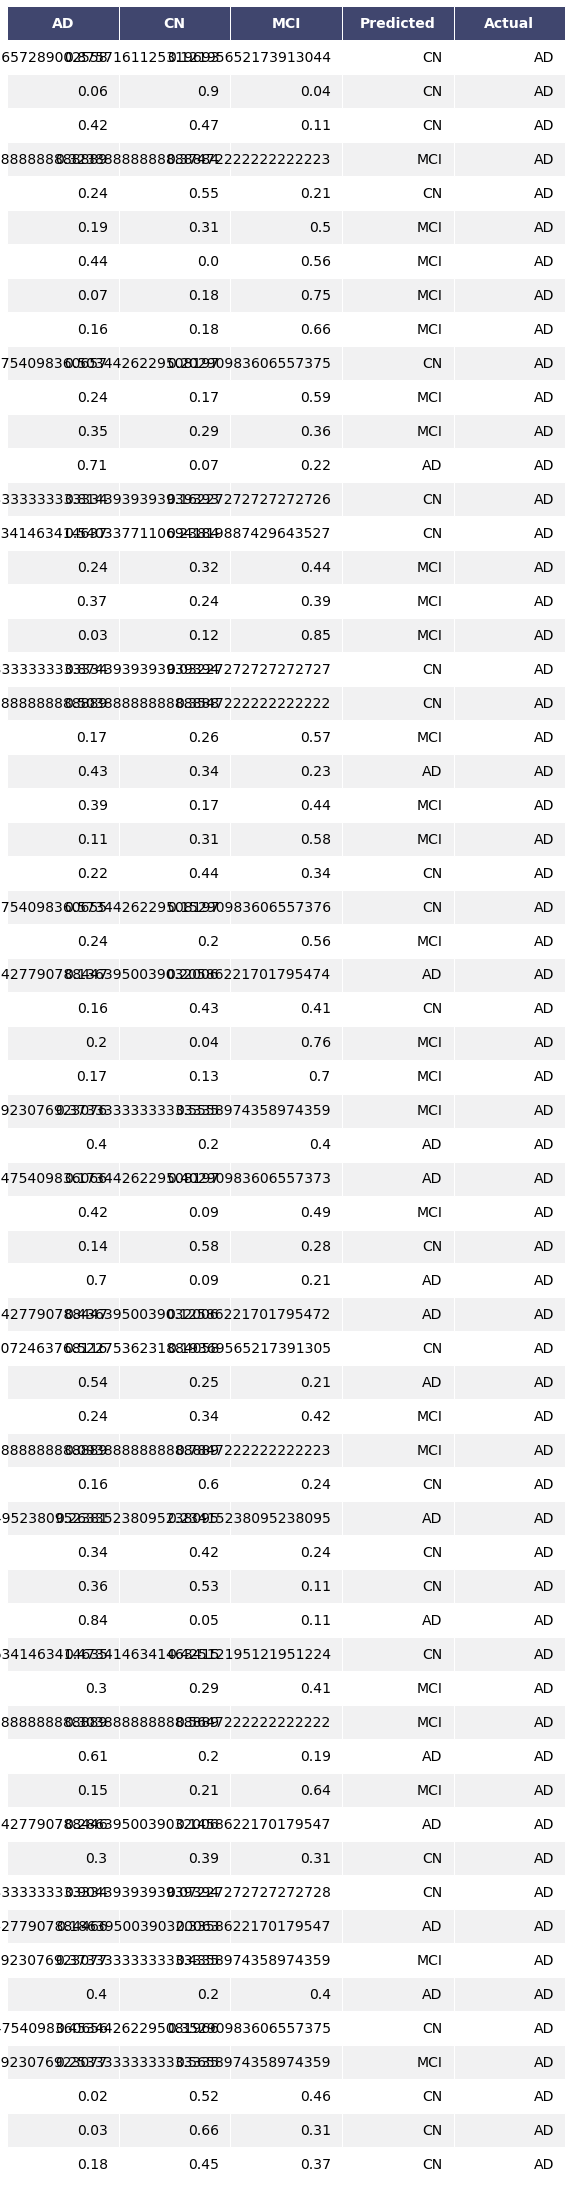

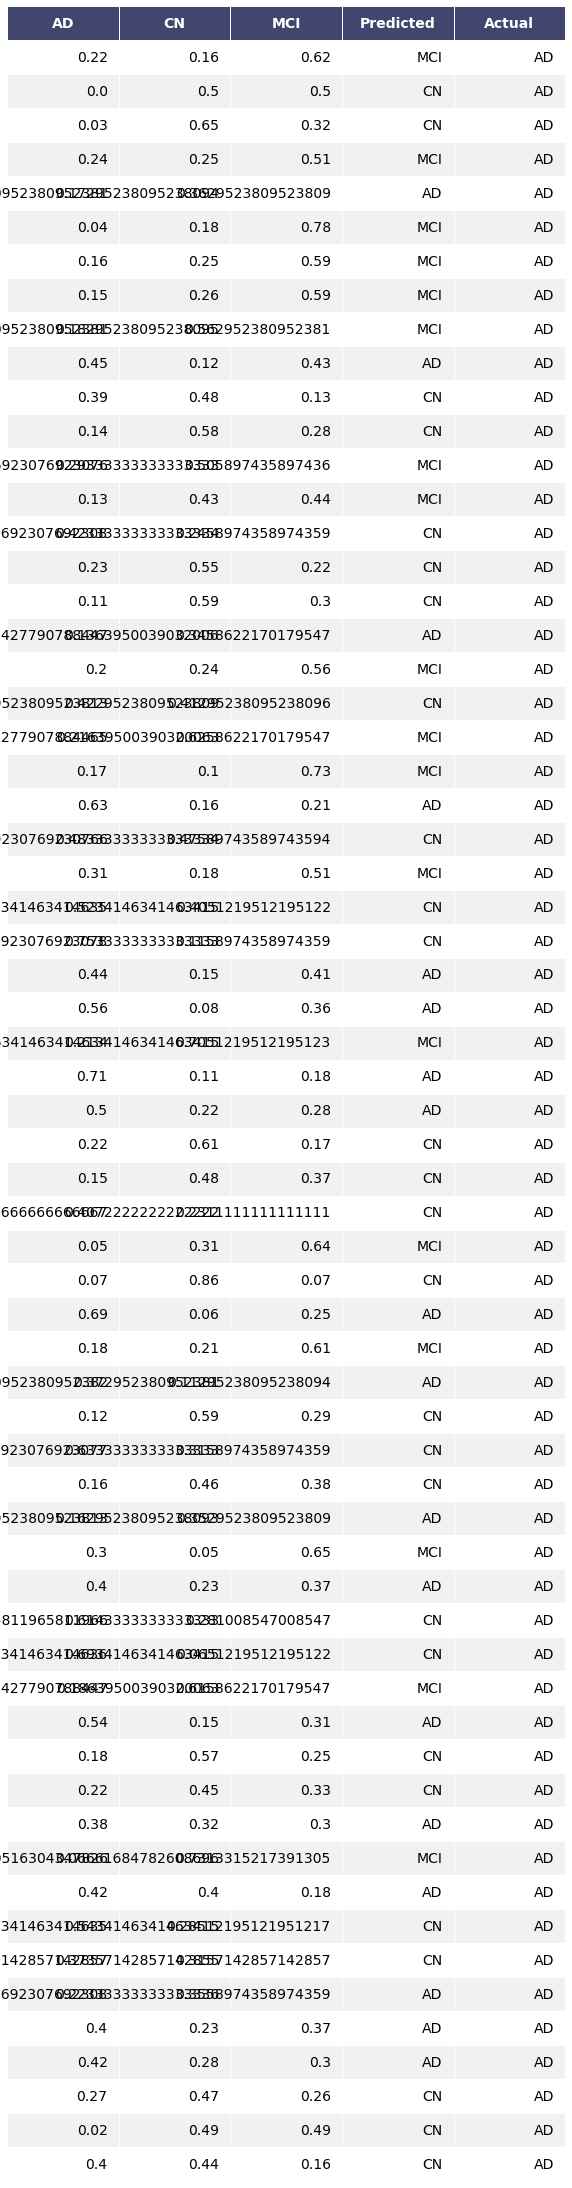

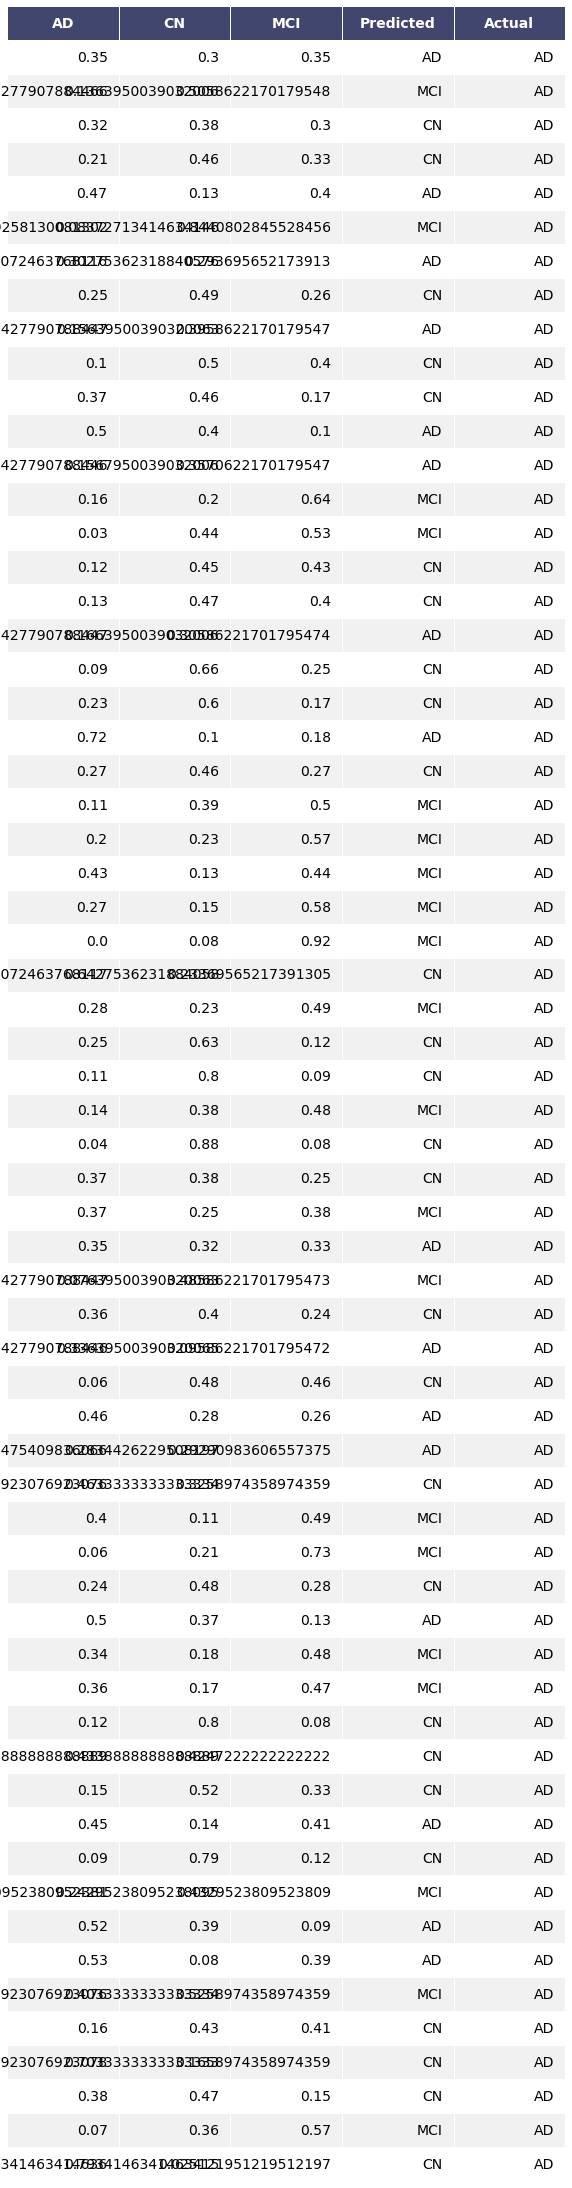

In [ ]:
#Create Table from Dataframe

df = df_test
df1 = df.iloc[0:63]
final_prediction = df1['Predicted'].value_counts()
df2 = df.iloc[63:126]
df3 = df.iloc[126:189]
df4 = df.iloc[189:252]



def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df1, header_columns=0, col_width=2.0)
fig.savefig("table1_mpl.png")
fig,ax = render_mpl_table(df2, header_columns=0, col_width=2.0)
fig.savefig("table2_mpl.png")
fig,ax = render_mpl_table(df3, header_columns=0, col_width=2.0)
fig.savefig("table3_mpl.png")
fig,ax = render_mpl_table(df4, header_columns=0, col_width=2.0)
fig.savefig("table4_mpl.png")